In [1]:
import torch, torchvision
from torch.utils.data import TensorDataset
from torch.utils.data import random_split
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
from tqdm import tqdm

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")
    print("No Cuda Available")
device  

device(type='cuda', index=0)

In [3]:
T = torchvision.transforms.Compose([
  torchvision.transforms.ToTensor(),
  # torchvision.transforms.Lambda(lambda x: torch.flatten(x))
])
train_set = torchvision.datasets.MNIST("mnist_data", train=True, download=True, transform=T)
print(train_set)
test_set = torchvision.datasets.MNIST("mnist_data", train=False, download=True, transform=T)
print(test_set)

Dataset MNIST
    Number of datapoints: 60000
    Root location: mnist_data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: mnist_data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [4]:
BATCH_SIZE = 64
train_dl = DataLoader(train_set, batch_size = BATCH_SIZE, shuffle=True)
test_dl = DataLoader(test_set, batch_size = 1, shuffle=True)

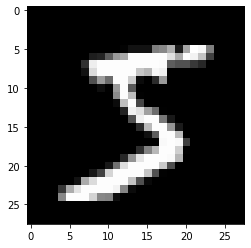

In [5]:
plt.imshow(train_set[0][0][0], cmap="gray")

# Variational Auto Encoder


In [56]:
class MNIST_VAE(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.kl = 0
        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda()
        self.N.scale = self.N.scale.cuda()

        self.encoder_conv = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(),
        )

        self.encoder_dense = nn.Sequential(
            nn.Flatten(),
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(),
        )

        self.bottleneck1 = nn.Linear(128, 2)
        self.bottleneck2 = nn.Linear(128, 2)

        self.decoder_dense = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 3*3*32),
            nn.ReLU(),
            nn.Unflatten(1, [32, 3, 3])
        )

        self.decoder_maxunpool = nn.MaxUnpool2d(2)

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoder_conv = self.encoder_conv(x)
        encoder_dense = self.encoder_dense(encoder_conv)

        mu = self.bottleneck1(encoder_dense)
        sigma = torch.exp(self.bottleneck2(encoder_dense))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()

        decoder_dense = self.decoder_dense(z)
        decoder_conv = self.decoder_conv(decoder_dense)
        return decoder_conv, z


In [57]:
vae = MNIST_VAE()
print(vae.eval())

MNIST_VAE(
  (encoder_conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (7): ReLU()
  )
  (encoder_dense): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=288, out_features=128, bias=True)
    (2): ReLU()
  )
  (bottleneck1): Linear(in_features=128, out_features=2, bias=True)
  (bottleneck2): Linear(in_features=128, out_features=2, bias=True)
  (decoder_dense): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU()
    (4): Unflatten(dim=1, unflattened_size=[32, 

  0%|          | 0/5 [00:00<?, ?it/s]

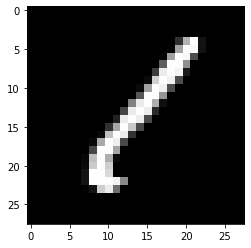

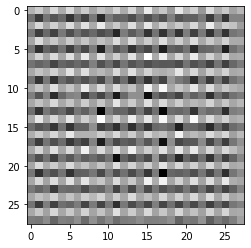

938it [00:35, 26.51it/s]
 20%|██        | 1/5 [00:35<02:21, 35.39s/it]

3550.5254918730843


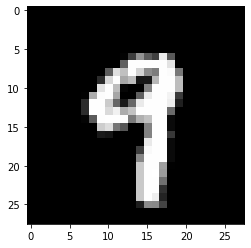

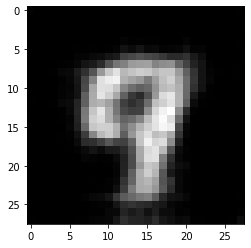

938it [00:33, 28.05it/s]
 40%|████      | 2/5 [01:08<01:42, 34.25s/it]

2417.527097657291


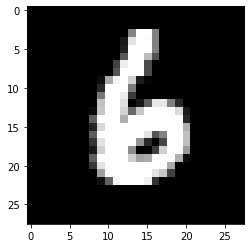

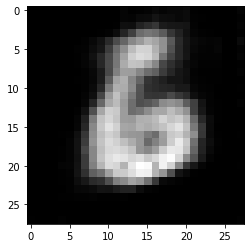

938it [00:33, 27.62it/s]
 60%|██████    | 3/5 [01:42<01:08, 34.12s/it]

2284.1174337879174


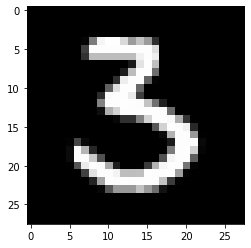

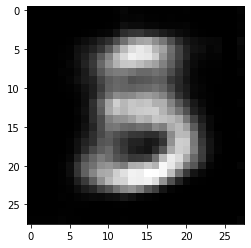

938it [00:35, 26.12it/s]
 80%|████████  | 4/5 [02:18<00:34, 34.83s/it]

2208.012738128207


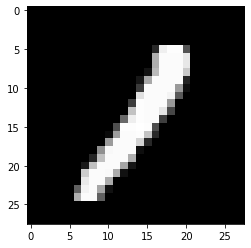

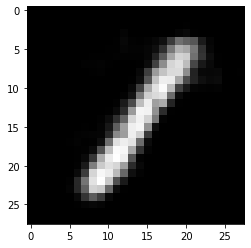

938it [00:35, 26.20it/s]
100%|██████████| 5/5 [02:54<00:00, 34.91s/it]

2160.1769294657433


In [58]:
torch.manual_seed(42)

EPOCHS = 5
vae = vae.to(device)
optimizer = torch.optim.Adam(vae.parameters(),
                             lr = 1e-3,
                             weight_decay = 1e-5)

for i in tqdm(range(EPOCHS)):
  sum_loss = 0 
  ctr = 0
  for j, (images, labels) in tqdm(enumerate(train_dl)):
    images = images.to(device)
    labels = labels.to(device)
    pred, bottlenecked = vae(images)

    #DISPLAY IMAGE
    if j == 0:
      plt.imshow(torch.squeeze(images)[0].cpu(), cmap="gray")
      plt.show()
      plt.imshow(torch.Tensor.cpu(torch.squeeze(pred[0])).detach().numpy(), cmap = "gray")
      plt.show()

    #MSE
    loss = ((images - pred)**2).sum() + 0.1*vae.kl
    
    #GRADIENT DESCENT
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #LOSS LOG
    sum_loss += loss.item()
    ctr += 1
  print(sum_loss/ctr)

torch.save(vae, "vae.pt")

In [60]:
encoded_samples = []
for sample in tqdm(test_set):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    vae.eval()
    with torch.no_grad():
       _, encoded_img  = vae(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)
    
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples


from sklearn.manifold import TSNE
import plotly.express as px

px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7, width=800, height=800)


100%|██████████| 10000/10000 [00:57<00:00, 175.12it/s]
